In [20]:
# Import niezbędnych bibliotek
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Ustawienie stylu wykresów
sns.set(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10, 6)

# --- DANE: wczytanie realnego zbioru (jeśli dostępny) lub generowanie danych syntetycznych ---
data_path = Path("insurance.csv")
if data_path.exists():
    df = pd.read_csv(data_path)
    print("Wczytano dane z pliku insurance.csv.")
else:
    # Generujemy dane, aby projekt był powtarzalny i nie wymagał zewnętrznego pliku csv.
    np.random.seed(42)
    n = 500  # Liczebność próby

    data = {
        'age': np.random.randint(18, 65, n),
        'sex': np.random.choice(['male', 'female'], n),
        'bmi': np.random.normal(30, 6, n),
        'children': np.random.choice([0, 1, 2, 3, 4, 5], n, p=[0.4, 0.25, 0.2, 0.1, 0.03, 0.02]),
        'smoker': np.random.choice(['yes', 'no'], n, p=[0.2, 0.8]),
        'region': np.random.choice(['southwest', 'southeast', 'northwest', 'northeast'], n)
    }

    df = pd.DataFrame(data)

    # Tworzenie zmiennej zależnej 'charges' z zaszytymi zależnościami + losowy szum
    # Formuła: Baza + Wiek + BMI + Palenie + Dzieci + Szum
    df['charges'] = (2000 +
                     df['age'] * 250 +
                     (df['bmi'] * 320) +
                     (df['smoker'].map({'yes': 23800, 'no': 0})) +
                     (df['children'] * 500) +
                     np.random.normal(0, 3000, n))

    # Zaokrąglenie do 2 miejsc po przecinku
    df['charges'] = df['charges'].round(2)

    print("Wygenerowano dane syntetyczne (brak pliku insurance.csv).")

display(df.head())
print(f"Rozmiar zbioru: {df.shape}")

Wczytano dane z pliku insurance.csv.


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Rozmiar zbioru: (1338, 7)


### Źródło danych
Notebook najpierw próbuje wczytać rzeczywisty plik `insurance.csv` (Medical Cost Personal Dataset).
Jeśli pliku nie ma w katalogu projektu, generowany jest syntetyczny zbiór o tej samej strukturze, aby zachować powtarzalność wyników.

## 1. Podstawowe parametry statystyczne
W tej sekcji wyznaczymy miary położenia (średnia, mediana), zmienności (odchylenie standardowe) oraz kształtu rozkładu (skośność, kurtoza) dla głównej zmiennej numerycznej `charges`.
Stworzymy również szereg rozdzielczy (histogram) w formie graficznej.

Charakterystyki liczbowe zmiennej 'charges':


,charges
count,1338.000000
mean,13270.422265
std,12110.011237
min,1121.873900
25%,4740.287150
50%,9382.033000
75%,16639.912515
max,63770.428010
skewness,1.515880
kurtosis,1.606299


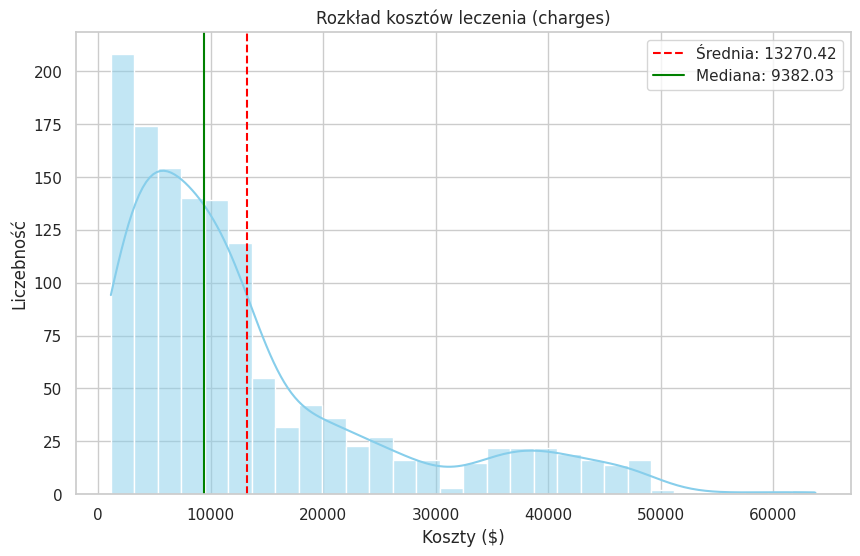

In [21]:
# Obliczenie statystyk
desc = df['charges'].describe()
skew = df['charges'].skew()
kurt = df['charges'].kurt()

# Wyświetlenie wyników w czytelnej ramce
stats_df = pd.DataFrame(desc)
stats_df.loc['skewness'] = skew
stats_df.loc['kurtosis'] = kurt
print("Charakterystyki liczbowe zmiennej 'charges':")
display(stats_df)

# Wizualizacja - Histogram z estymacją gęstości (KDE)
plt.figure(figsize=(10, 6))
sns.histplot(df['charges'], kde=True, bins=30, color='skyblue')
plt.title('Rozkład kosztów leczenia (charges)')
plt.xlabel('Koszty ($)')
plt.ylabel('Liczebność')
plt.axvline(desc['mean'], color='red', linestyle='--', label=f'Średnia: {desc["mean"]:.2f}')
plt.axvline(desc['50%'], color='green', linestyle='-', label=f'Mediana: {desc["50%"]:.2f}')
plt.legend()
plt.show()

## 2. Testy Parametryczne (Test t-Studenta)
**Hipoteza badawcza:** Osoby palące ponoszą wyższe koszty leczenia niż osoby niepalące.
* $H_0$: Średnie koszty w obu grupach są równe ($\mu_{palacz} = \mu_{niepalacz}$).
* $H_1$: Średnie koszty są różne ($\mu_{palacz} \neq \mu_{niepalacz}$).

Najpierw sprawdzimy założenie o równości wariancji testem Levene'a.

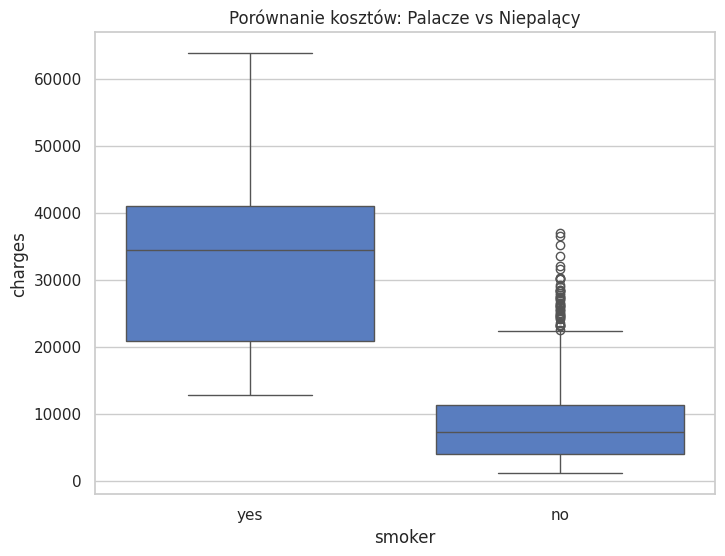

Test Levene'a: p-value = 0.0000

Wyniki testu t-Studenta:
Statystyka t: 32.75
Wartość p (p-value): 5.8895e-103
WNIOSEK: Odrzucamy hipotezę zerową. Istnieje istotna statystycznie różnica w kosztach.


In [22]:
# Podział na grupy
group_smoker = df[df['smoker'] == 'yes']['charges']
group_nonsmoker = df[df['smoker'] == 'no']['charges']

# Wizualizacja różnic (Boxplot)
plt.figure(figsize=(8, 6))
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Porównanie kosztów: Palacze vs Niepalący')
plt.show()

# 1. Test Levene'a (równość wariancji)
stat_levene, p_levene = stats.levene(group_smoker, group_nonsmoker)
print(f"Test Levene'a: p-value = {p_levene:.4f}")

# Decyzja o parametrze equal_var
equal_var_assumption = p_levene > 0.05

# 2. Test t-Studenta
t_stat, p_val_t = stats.ttest_ind(group_smoker, group_nonsmoker, equal_var=equal_var_assumption)

print(f"\nWyniki testu t-Studenta:")
print(f"Statystyka t: {t_stat:.2f}")
print(f"Wartość p (p-value): {p_val_t:.4e}")

if p_val_t < 0.05:
    print("WNIOSEK: Odrzucamy hipotezę zerową. Istnieje istotna statystycznie różnica w kosztach.")
else:
    print("WNIOSEK: Brak podstaw do odrzucenia H0.")

## 3. Testy Nieparametryczne
Wykorzystamy je, gdy założenia o normalności rozkładu nie są spełnione.
1. **Test Shapiro-Wilka:** Sprawdzenie normalności rozkładu zmiennej `bmi`.
2. **Test Manna-Whitneya:** Nieparametryczny odpowiednik testu t-Studenta (porównanie kosztów dla płci: Kobiety vs Mężczyźni).

In [23]:
# A. Test normalności Shapiro-Wilka dla BMI
stat_sw, p_sw = stats.shapiro(df['bmi'])
print(f"Test Shapiro-Wilka dla BMI: p-value = {p_sw:.4f}")

if p_sw > 0.05:
    print("-> Rozkład BMI przypomina rozkład normalny.")
else:
    print("-> Rozkład BMI różni się od normalnego.")

# B. Test Manna-Whitneya dla zmiennej 'sex' (Kobiety vs Mężczyźni)
# Sprawdzamy, czy płeć różnicuje koszty (nie zakładając normalności rozkładu kosztów)
group_female = df[df['sex'] == 'female']['charges']
group_male = df[df['sex'] == 'male']['charges']

u_stat, p_mw = stats.mannwhitneyu(group_female, group_male)
print(f"\nTest Manna-Whitneya (Płeć vs Koszty): p-value = {p_mw:.4f}")

if p_mw < 0.05:
    print("WNIOSEK: Istnieje istotna różnica w kosztach między kobietami a mężczyznami.")
else:
    print("WNIOSEK: Płeć nie różnicuje istotnie kosztów w tym zbiorze.")

Test Shapiro-Wilka dla BMI: p-value = 0.0000
-> Rozkład BMI różni się od normalnego.

Test Manna-Whitneya (Płeć vs Koszty): p-value = 0.7287
WNIOSEK: Płeć nie różnicuje istotnie kosztów w tym zbiorze.


## 4. Analiza Wariancji (ANOVA)
Sprawdzimy, czy region zamieszkania (`southwest`, `southeast`, `northwest`, `northeast`) wpływa na wysokość opłat.

* $H_0$: Średnie koszty we wszystkich regionach są takie same.
* $H_1$: Przynajmniej jedna średnia różni się od pozostałych.

Tabela ANOVA:


,sum_sq,df,F,PR(>F)
C(region),1.300760e+09,3.0,2.969627,0.030893
Residual,1.947735e+11,1334.0,NaN,NaN



Wynik istotny statystycznie (p=0.0309). Region ma wpływ na koszty.


/tmp/ipykernel_4658/3010269938.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_val_anova = anova_table['PR(>F)'][0]
/tmp/ipykernel_4658/3010269938.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='region', y='charges', data=df, palette="Set2")


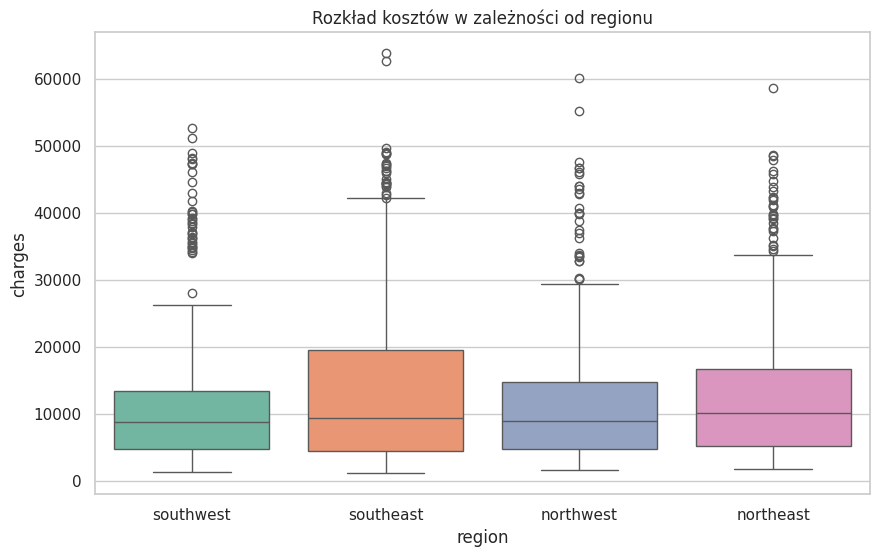

In [24]:
# Model ANOVA
model_anova = ols('charges ~ C(region)', data=df).fit()
anova_table = sm.stats.anova_lm(model_anova, typ=2)

print("Tabela ANOVA:")
display(anova_table)

# Interpretacja
p_val_anova = anova_table['PR(>F)'][0]
if p_val_anova < 0.05:
    print(f"\nWynik istotny statystycznie (p={p_val_anova:.4f}). Region ma wpływ na koszty.")
else:
    print(f"\nWynik nieistotny statystycznie (p={p_val_anova:.4f}). Region nie ma wpływu na koszty.")

# Wykres pudełkowy dla regionów
plt.figure(figsize=(10, 6))
sns.boxplot(x='region', y='charges', data=df, palette="Set2")
plt.title('Rozkład kosztów w zależności od regionu')
plt.show()

## 5. Analiza Regresji Wielorakiej
Zbudujemy model liniowy przewidujący `charges` na podstawie zmiennych: `age`, `bmi`, `children`.
Równanie modelu:
$$Y = \beta_0 + \beta_1 X_{age} + \beta_2 X_{bmi} + \beta_3 X_{children} + \epsilon$$

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     60.69
Date:                Sat, 17 Jan 2026   Prob (F-statistic):           8.80e-37
Time:                        18:34:32   Log-Likelihood:                -14392.
No. Observations:                1338   AIC:                         2.879e+04
Df Residuals:                    1334   BIC:                         2.881e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6916.2433   1757.480     -3.935      0.0

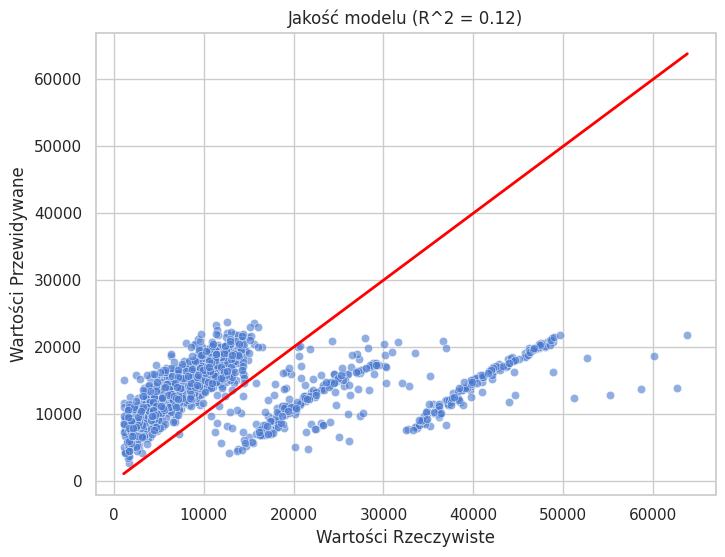

In [25]:
# Przygotowanie zmiennych
# Dodajemy stałą (intercept) do modelu
X = df[['age', 'bmi', 'children']]
X = sm.add_constant(X)
y = df['charges']

# Dopasowanie modelu OLS (Ordinary Least Squares)
model_reg = sm.OLS(y, X).fit()

# Wyświetlenie pełnego raportu
print(model_reg.summary())

# Wizualizacja dopasowania: Wykres rzeczywiste vs przewidywane
predictions = model_reg.predict(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=predictions, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', lw=2) # Linia idealnego dopasowania
plt.xlabel('Wartości Rzeczywiste')
plt.ylabel('Wartości Przewidywane')
plt.title(f'Jakość modelu (R^2 = {model_reg.rsquared:.2f})')
plt.show()